# BMGF TTS Evaluation
* This notebook contains clean, abstracted classes to enable pipelined comparison of ML algorithms and feature sets
  

## Methods and globals

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sb

import warnings
import hashlib
import pickle
import os
import json

from time import sleep
from matplotlib import pyplot as plt
from neuralprophet import NeuralProphet, set_log_level, set_random_seed
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

import MeaslesDataLoader as md

sb.set_context("poster")
sb.set_theme()

%matplotlib inline

warnings.simplefilter(action='ignore', category=FutureWarning)
set_log_level("ERROR")

/opt/miniconda3/envs/Measles/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


## Utility functions

In [2]:
def prepCurve(df,
              depVar,
              indepVars):
    """Prepares one curve df, paring out all unnecessary attributes"""
    df.rename({depVar:'y'},
               axis=1,
               inplace = True)

    indepVars = {key:duration for key,duration in indepVars.items() if key in df.columns}
    indepVars = {key:duration for key,duration in indepVars.items() if len(df[key].dropna()) > 0}
    df = df[['ds','y']+list(indepVars.keys())]
    df = df.dropna(subset=['y'],axis=0)
    
    return df,indepVars


def hashIt(var):
    """Returns an md5 hash from an arbitrary variable"""
    
    md5_hash_obj = hashlib.md5()
    md5_hash_obj.update(str(var).encode('utf-8'))
    return md5_hash_obj.hexdigest()



def evaluateModel(trained):
    """Evaluates any trained model from generic TTS parameters"""

    
    mseTest = mean_squared_error(trained.yTest, trained.yTestPred)
    maeTest = mean_absolute_error(trained.yTest, trained.yTestPred)
    r2Test = r2_score(trained.yTest, trained.yTestPred)
    mseTrain = mean_squared_error(trained.yTrain, trained.yTrainPred)
    maeTrain = mean_absolute_error(trained.yTrain, trained.yTrainPred)
    r2Train = r2_score(trained.yTrain, trained.yTrainPred)

    result = {'Test MSE':mseTest,
              'Test MAE':maeTest,
              'Test R2':r2Test,
              'Train MSE':mseTrain,
              'Train MAE':maeTrain,
              'Train R2':r2Train}
    
    return result



def alignEvalData(original,predicted):
    """Takes two iterables of the same length and drops rows where either is missing a value"""
    merged = pd.DataFrame({'original':original,
                           'predicted':predicted}).dropna()
    
    return merged.original, merged.predicted



def evaluateModel(trained):
    """Evaluates any trained model from generic TTS parameters"""

    yTest,yTestPred = alignEvalData(trained.yTest,trained.yTestPred)
    yTrain,yTrainPred = alignEvalData(trained.yTrain,trained.yTrainPred)

    
    mseTest = mean_squared_error(yTest, yTestPred)
    maeTest = mean_absolute_error(yTest, yTestPred)
    r2Test = r2_score(yTest, yTestPred)
    mseTrain = mean_squared_error(yTrain, yTrainPred)
    maeTrain = mean_absolute_error(yTrain, yTrainPred)
    r2Train = r2_score(yTrain, yTrainPred)

    result = {'Test MSE':mseTest,
              'Test MAE':maeTest,
              'Test R2':r2Test,
              'Train MSE':mseTrain,
              'Train MAE':maeTrain,
              'Train R2':r2Train}
    
    return result



def projectPredictor(dfIn,
                     var,
                     periods,
                     method = 'NeuralProphet autoregression',
                     forcePositive = True,
                     randomState = 1337):
    """Projects a single predictor n periods into the future"""
    
    df = dfIn[['ds',var]].copy(deep=True)
    df.columns = ['ds','y']

    hash = hashIt((df,
                   var,
                   periods,
                   forcePositive,
                   method,
                   randomState))
    
    cacheFile = f'store/{hash}Predictor.pkl'
    
    if os.path.exists(cacheFile):
        with open(cacheFile, 'rb') as fileIn:
            predictor = pickle.load(fileIn)
        return predictor

    
    if method == 'NeuralProphet autoregression':
        set_random_seed(randomState)
        model = NeuralProphet()
        metrics = model.fit(df,freq='M')
        future = model.make_future_dataframe(df,
                                             periods=periods,
                                             n_historic_predictions=True)
        forecast = model.predict(future)
        forecast['y'].fillna(forecast['yhat1'],inplace=True)
    
        result = forecast[['ds','y']]
        result.columns = ['ds',var]
        

    with open(cacheFile, 'wb') as fileOut:
        pickle.dump(result, fileOut, protocol=pickle.HIGHEST_PROTOCOL)

    return result
    

def plotTTS(simObject):
    """Quick plotting function for TTS objects"""
    forecast = simObject.trained['forecast'].copy(deep=True)
    withheld = simObject.curve[-simObject.testSize:].copy(deep=True)
    withheld.rename({'y':'withheld'},
                    axis = 1,
                    inplace = True)
    forecast.rename({'y':'training data','yhat1':'prediction'},
                    axis = 1,
                    inplace = True)
    
    fig, ax = plt.subplots(figsize=(8,6))
    forecast.plot(x = 'ds',
                  y = ['training data','prediction'],
                  alpha = .5,
                  ax = ax)
    withheld.plot(x = 'ds',
                  y = 'withheld',
                  alpha = .5,
                  ax = ax,)
    plt.xlabel("Month/Year")
    plt.ylabel(simObject.depVar)
    plt.title(f"{simObject.country} {simObject.depVar} vs predictors {simObject.features}\nMethod: {simObject.method}")


# Initial data load

In [3]:
preppedCountries = md.prepData()
preppedCountries['Gabon'].tail()

129/194 included countries found with noted outbreaks.


,cases,cases_1M,births,birth_per_1k,mnths_since_outbreak_20_per_M,mnths_since_outbreak_2_per_M,mnths_since_outbreak_20_cuml_per_M,mean_precip_mm_per_day,total_precip_mm_per_day,measles_kw_trend,outbreak_20_per_M,outbreak_2_per_M,outbreak_20_cuml_per_M,ds,MCV1
9853,0.0,0.000000,63760,26.174,6.0,5.0,0.0,9.523333,28.57,0.0,0,0,0,2023-11-01,NaN
9854,6.0,2.486760,63760,26.174,7.0,0.0,0.0,5.496667,16.49,0.0,0,0,0,2023-12-01,NaN
9855,2.0,0.812891,63677,25.634,8.0,1.0,1.0,1.923333,5.77,0.0,0,0,0,2024-01-01,NaN
9856,0.0,0.000000,63677,25.634,9.0,2.0,2.0,3.946667,11.84,0.0,0,0,0,2024-02-01,NaN
9857,NaN,NaN,63677,25.634,10.0,3.0,3.0,7.716667,23.15,0.0,0,0,0,2024-03-01,NaN


# Train Test Split wrappers

## Neural Prophet lagged regressors class

In [4]:
class npLaggedTTS:
    def __init__(self,
                 country,
                 depVar,
                 indepVars,
                 projectionMethod = 'NeuralProphet autoregression',
                 testSize = 12,
                 randomState = 1337):
        """
        Initialize the model parameters
        """
        curve = preppedCountries[country].copy(deep=True)
        self.country = country
        self.depVar = depVar
        self.curve, self.indepVars = prepCurve(curve,
                                               depVar,
                                               indepVars)

        self.modelArgs = dict()
        self.features = indepVars
        varKeys = sorted(list(self.indepVars.keys()))
        
        self.testSize = testSize
        self.randomState = randomState
        self.trainDf, self.testDf  = train_test_split(self.curve,
                                                      shuffle = False,
                                                      test_size = self.testSize)
        self.method = 'NeuralProphet lagged regressors'
        self.projection = projectionMethod
        self.hash = hashIt((self.curve,
                            testSize,
                            randomState,
                            self.features,
                            self.method,
                            self.projection,
                            self.modelArgs))

        self.xTrain = self.trainDf[varKeys].values
        self.yTrain = self.trainDf['y'].values
        self.xTest = self.testDf[varKeys].values
        self.yTest = self.testDf['y'].values

        self.trained = None
        self.yTestPred = None
        self.yTrainPred = None
        self.results = None

    def train(self):
        """
        Trains the model, loading from cache if previously trained
        """

        cacheFile = f'store/{self.hash}Trained.pkl'
        set_random_seed(self.randomState)
        
        if os.path.exists(cacheFile):
            with open(cacheFile, 'rb') as fileIn:
                self.trained = pickle.load(fileIn)
        
        else:
            model = NeuralProphet()
            
            for indepVar,delay in self.indepVars.items():
                print(indepVar,delay)
                model.add_lagged_regressor(indepVar, n_lags=delay)
                
            metrics = model.fit(self.trainDf,
                                freq='M')


            if self.features == dict():
                future = model.make_future_dataframe(self.trainDf,
                                                     periods=self.testSize,
                                                     n_historic_predictions=True)
            else:
                future = self.trainDf.copy(deep=True)
                for indepVar,delay in self.indepVars.items():
                    predictor = projectPredictor(self.trainDf,
                                                 indepVar,
                                                 self.testSize,
                                                 method = self.projection,
                                                 randomState = self.randomState)
                    future = future.merge(predictor,how='outer')
            
            forecast = model.predict(future)
            result = {'train':self.trainDf,
                      'metrics':metrics,
                      'future':future,
                      'forecast':forecast,
                      'model':model,}
    
            with open(cacheFile, 'wb') as fileOut:
                pickle.dump(result, fileOut, protocol=pickle.HIGHEST_PROTOCOL)

            self.trained = result

        self.yTestPred = self.trained['forecast']['yhat1'][-self.testSize:].values
        self.yTrainPred = self.trained['forecast']['yhat1'][:-self.testSize].values

    

    def evaluate(self):
        """
        Returns evaluation data
        """
        if self.trained is None:
            raise ValueError("Model has not been trained yet, call that first.")


        results = evaluateModel(self)
        modelParams = {'method':self.method,
                       'predictor projection':self.projection,
                       'depVar':self.depVar,
                       'indepVars':self.features,
                       'withheld':self.testSize,
                       'random state':self.randomState,
                       'model args':str(self.modelArgs)}

        results.update(modelParams)
        return results


mnths_since_outbreak_20_per_M 3


Finding best initial lr: 100%|███████████████| 209/209 [00:00<00:00, 761.78it/s]


Epoch 220: 100%|█| 220/220 [00:00<00:00, 13939.20it/s, loss=0.0434, v_num=19, MA


Finding best initial lr: 100%|███████████████| 209/209 [00:00<00:00, 815.73it/s]


Epoch 210: 100%|█| 210/210 [00:00<00:00, 12618.79it/s, loss=0.087, v_num=20, MAE
Predicting DataLoader 0: 100%|███████████████████| 1/1 [00:00<00:00, 658.24it/s]


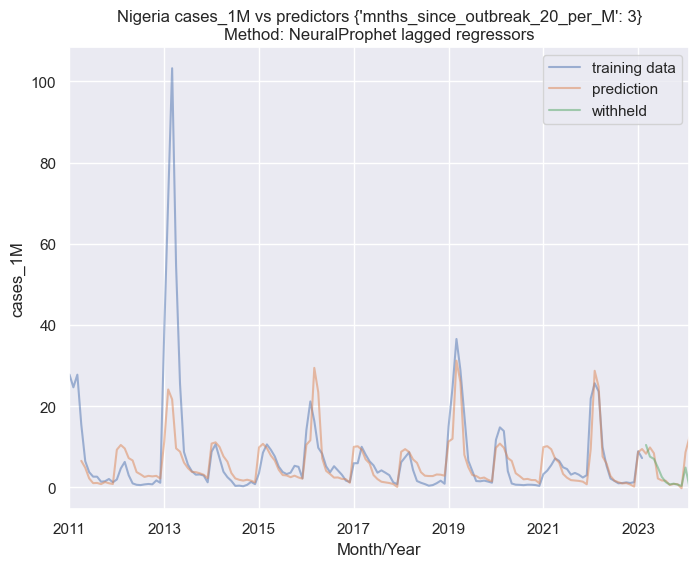

In [16]:
neuralRun = npLaggedTTS('Nigeria', 'cases_1M', indepVars = {'mnths_since_outbreak_20_per_M':3}, testSize = 12)
neuralRun.train()
plotTTS(neuralRun)

mnths_since_outbreak_20_cuml_per_M 3


Finding best initial lr: 100%|███████████████| 209/209 [00:00<00:00, 723.85it/s]


Epoch 220: 100%|█| 220/220 [00:00<00:00, 13091.21it/s, loss=0.0532, v_num=21, MA


Finding best initial lr: 100%|███████████████| 209/209 [00:00<00:00, 834.96it/s]


Epoch 210: 100%|█| 210/210 [00:00<00:00, 12336.36it/s, loss=0.0672, v_num=22, MA
Predicting DataLoader 0: 100%|███████████████████| 1/1 [00:00<00:00, 544.93it/s]


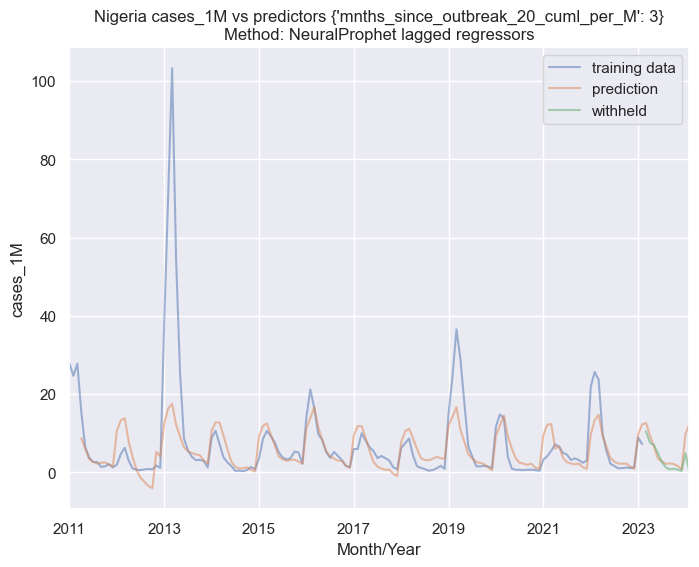

In [18]:
neuralRun = npLaggedTTS('Nigeria', 'cases_1M', indepVars = {'mnths_since_outbreak_20_cuml_per_M':3}, testSize = 12)
neuralRun.train()
plotTTS(neuralRun)

## Neural Prophet future regressors class 

In [ ]:
class npFutureTTS:
    def __init__(self,
                 country,
                 depVar,
                 indepVars,
                 projectionMethod = 'NeuralProphet autoregression',
                 testSize = 12,
                 randomState = 1337):
        """
        Initialize the model parameters
        """
        curve = preppedCountries[country].copy(deep=True)
        self.depVar = depVar
        self.country = country
        self.curve, self.indepVars = prepCurve(curve,
                                               depVar,
                                               indepVars)

        self.modelArgs = dict()
        self.features = sorted(list(self.indepVars.keys()))
        
        self.testSize = testSize
        self.randomState = randomState
        self.trainDf, self.testDf  = train_test_split(self.curve,
                                                      shuffle = False,
                                                      test_size = self.testSize)
        self.method = 'NeuralProphet future regressors'
        self.projection = projectionMethod
        self.hash = hashIt((self.curve,
                            testSize,
                            randomState,
                            self.features,
                            self.method,
                            self.projection,
                            self.modelArgs))

        self.xTrain = self.trainDf[self.features].values
        self.yTrain = self.trainDf['y'].values
        self.xTest = self.testDf[self.features].values
        self.yTest = self.testDf['y'].values

        self.trained = None
        self.yTestPred = None
        self.yTrainPred = None
        self.results = None

    def train(self):
        """
        Trains the model, loading from cache if previously trained
        """

        cacheFile = f'store/{self.hash}Trained.pkl'
        set_random_seed(self.randomState)
        
        if os.path.exists(cacheFile):
            with open(cacheFile, 'rb') as fileIn:
                self.trained = pickle.load(fileIn)
        
        else:
            model = NeuralProphet()
            
            
            for indepVar,delay in self.indepVars.items():
                model.add_future_regressor(indepVar)

            metrics = model.fit(self.trainDf,
                                freq='M')


            if self.features == []:
                future = model.make_future_dataframe(self.trainDf,
                                                     periods=self.testSize,
                                                     n_historic_predictions=True)
            else:
                future = self.trainDf.copy(deep=True)
                for indepVar,delay in self.indepVars.items():
                    predictor = projectPredictor(self.trainDf,
                                                 indepVar,
                                                 self.testSize,
                                                 method = self.projection,
                                                 randomState = self.randomState)
                    future = future.merge(predictor,how='outer')
        
            
            forecast = model.predict(future)
            result = {'train':self.trainDf,
                      'metrics':metrics,
                      'future':future,
                      'forecast':forecast,
                      'model':model,}
    
            with open(cacheFile, 'wb') as fileOut:
                pickle.dump(result, fileOut, protocol=pickle.HIGHEST_PROTOCOL)

            self.trained = result

        self.yTestPred = self.trained['forecast']['yhat1'][-self.testSize:].values
        self.yTrainPred = self.trained['forecast']['yhat1'][:-self.testSize].values

    

    def evaluate(self):
        """
        Returns evaluation data
        """
        if self.trained is None:
            raise ValueError("Model has not been trained yet, call that first.")


        results = evaluateModel(self)
        modelParams = {'method':self.method,
                       'predictor projection':self.projection,
                       'depVar':self.depVar,
                       'indepVars':self.features,
                       'withheld':self.testSize,
                       'random state':self.randomState,
                       'model args':str(self.modelArgs)}

        results.update(modelParams)
        return results

In [ ]:
neuralRun = npFutureTTS('Nigeria',
                        'cases_1M',
                        indepVars = {'total_precip_mm_per_day':3},
                        testSize = 12)

neuralRun.train()
plotTTS(neuralRun)
neuralRun.evaluate()

## Scikit-learn gradient boosting regression trees class

In [ ]:
class sklGradientBoostingRegression:
    def __init__(self,
                 country,
                 depVar,
                 indepVars,
                 projectionMethod = 'NeuralProphet autoregression',
                 testSize = 12,
                 randomState = 1337):
        """
        Initialize the model parameters
        """
        curve = preppedCountries[country].copy(deep=True)
        self.depVar = depVar
        self.country = country
        self.curve, self.indepVars = prepCurve(curve,
                                               depVar,
                                               indepVars)

        self.modelArgs = dict()
        self.features = sorted(list(self.indepVars.keys()))
        
        self.testSize = testSize
        self.randomState = randomState
        self.trainDf, self.testDf  = train_test_split(self.curve,
                                                      shuffle = False,
                                                      test_size = self.testSize)
        self.method = 'Scikit-learn gradient boosted regression'
        self.projection = projectionMethod
        self.hash = hashIt((self.curve,
                            testSize,
                            randomState,
                            self.features,
                            self.method,
                            self.projection,
                            self.modelArgs))

        self.xTrain = self.trainDf[self.features].values
        self.yTrain = self.trainDf['y'].values
        self.xTest = self.testDf[self.features].values
        self.yTest = self.testDf['y'].values

        self.trained = None
        self.yTestPred = None
        self.yTrainPred = None
        self.results = None

    def train(self):
        """
        Trains the model, loading from cache if previously trained
        """

        cacheFile = f'store/{self.hash}Trained.pkl'
        set_random_seed(self.randomState)
        
        if os.path.exists(cacheFile) and False:
            with open(cacheFile, 'rb') as fileIn:
                self.trained = pickle.load(fileIn)
        
        else:
            model = GradientBoostingRegressor(random_state=self.randomState)
            model.fit(self.xTrain, self.yTrain)


            if self.features == []:
                raise ValueError("Model cannot be trained without one or more independent variables.")
            else:
                future = self.trainDf.copy(deep=True)
                for indepVar,delay in self.indepVars.items():
                    predictor = projectPredictor(self.trainDf,
                                                 indepVar,
                                                 self.testSize,
                                                 method = self.projection,
                                                 randomState = self.randomState)
                    future = future.merge(predictor,how='outer')

            
            forecast = model.predict(future[self.features].values)
            
            result = {'train':self.trainDf,
                      'future':future,
                      'forecast':forecast,
                      'model':model,}
    
            with open(cacheFile, 'wb') as fileOut:
                pickle.dump(result, fileOut, protocol=pickle.HIGHEST_PROTOCOL)

            self.trained = result

        self.yTestPred = self.trained['forecast'][-self.testSize:]
        self.yTrainPred = self.trained['forecast'][:-self.testSize]

    

    def evaluate(self):
        """
        Returns evaluation data
        """
        if self.trained is None:
            raise ValueError("Model has not been trained yet, call that first.")


        results = evaluateModel(self)
        modelParams = {'method':self.method,
                       'predictor projection':self.projection,
                       'depVar':self.depVar,
                       'indepVars':self.features,
                       'withheld':self.testSize,
                       'random state':self.randomState,
                       'model args':str(self.modelArgs)}

        results.update(modelParams)
        return results

In [ ]:
gbrRun = sklGradientBoostingRegression('Nigeria',
                                       'cases_1M',
                                       indepVars = {'total_precip_mm_per_day':3},
                                       testSize = 12)

gbrRun.train()
#plotTTS(gbrRun)    # Not implemented yet for scikit-learn wrappers
gbrRun.evaluate()

## Scikit-learn generic regression wrapper class
* Many of these cause spurious python kernel crashes that try/except will not catch

In [ ]:
class sklGeneric:
    def __init__(self,
                 country,
                 depVar,
                 indepVars,
                 projectionMethod = 'NeuralProphet autoregression',
                 testSize = 12,
                 randomState = 1337,
                 modelArgs = dict()):
        """
        Initialize the model parameters
        """
        curve = preppedCountries[country].copy(deep=True)
        self.depVar = depVar
        self.country = country
        self.curve, self.indepVars = prepCurve(curve,
                                               depVar,
                                               indepVars)

        self.features = sorted(list(self.indepVars.keys()))
        
        self.testSize = testSize
        self.randomState = randomState
        self.trainDf, self.testDf  = train_test_split(self.curve,
                                                      shuffle = False,
                                                      test_size = self.testSize)
        self.method = f'Scikit-learn generic: {modelArgs["modelName"]}'
        self.modelArgs = modelArgs
        self.projection = projectionMethod
        self.hash = hashIt((self.curve,
                            testSize,
                            randomState,
                            self.features,
                            self.method,
                            self.projection,
                            self.modelArgs))

        self.xTrain = self.trainDf[self.features].values
        self.yTrain = self.trainDf['y'].values
        self.xTest = self.testDf[self.features].values
        self.yTest = self.testDf['y'].values

        self.trained = None
        self.yTestPred = None
        self.yTrainPred = None
        self.results = None

    def train(self):
        """
        Trains the model, loading from cache if previously trained
        """

        cacheFile = f'store/{self.hash}Trained.pkl'
        set_random_seed(self.randomState)
        
        if os.path.exists(cacheFile) and False:
            with open(cacheFile, 'rb') as fileIn:
                self.trained = pickle.load(fileIn)
        
        else:
            print(self.modelArgs)
            model = self.modelArgs['model'](random_state=self.randomState)
            model.fit(self.xTrain, self.yTrain)


            if self.features == []:
                raise ValueError("Model cannot be trained without one or more independent variables.")
            else:
                future = self.trainDf.copy(deep=True)
                for indepVar,delay in self.indepVars.items():
                    predictor = projectPredictor(self.trainDf,
                                                 indepVar,
                                                 self.testSize,
                                                 method = self.projection,
                                                 randomState = self.randomState)
                    future = future.merge(predictor,how='outer')

            
            forecast = model.predict(future[self.features].values)
            
            result = {'train':self.trainDf,
                      'future':future,
                      'forecast':forecast,
                      'model':model,}
    
            with open(cacheFile, 'wb') as fileOut:
                pickle.dump(result, fileOut, protocol=pickle.HIGHEST_PROTOCOL)

            self.trained = result

        self.yTestPred = self.trained['forecast'][-self.testSize:]
        self.yTrainPred = self.trained['forecast'][:-self.testSize]

    

    def evaluate(self):
        """
        Returns evaluation data
        """
        if self.trained is None:
            raise ValueError("Model has not been trained yet, call that first.")


        results = evaluateModel(self)
        modelParams = {'method':self.method,
                       'predictor projection':self.projection,
                       'depVar':self.depVar,
                       'indepVars':self.features,
                       'withheld':self.testSize,
                       'random state':self.randomState,
                       'model args':str(self.modelArgs)}

        results.update(modelParams)
        return results

In [ ]:
genericArgs = {'model':HistGradientBoostingRegressor,
             'modelName': 'hist gradient boosting regressor'}

genericRun = sklGeneric('Nigeria',
                        'cases_1M',
                        indepVars = {'total_precip_mm_per_day':3},
                        modelArgs = genericArgs,
                        testSize = 12)

genericRun.train()
#plotTTS(gbrRun)    # Not implemented yet for scikit-learn wrappers
genericRun.evaluate()

# Examples

## Ensemble modelling method sweep via skl generic wrapper

In [ ]:
import sklearn.ensemble
import inspect

members = inspect.getmembers(sklearn.ensemble, inspect.isclass)

regressorClasses = [{'modelName':name,
                     'model':cls} for name, cls in members if cls.__module__.startswith('sklearn.ensemble')]

#notWorking ={'GradientBoostingRegressor','ExtraTreesRegressor'}
notWorking = {}


for regressorModelArgs in regressorClasses:
    modelName = regressorModelArgs['modelName']
    if modelName.endswith('Regressor') and modelName not in notWorking:
        try:
            print(f"Preparing to run {modelName}")
            genericRun = sklGeneric('Nigeria',
                                'cases_1M',
                                indepVars = {'total_precip_mm_per_day':3},
                                modelArgs = regressorModelArgs,
                                testSize = 12)
        
            print("Training....")
            genericRun.train()
            print("Evaluating...")
            result = genericRun.evaluate()
            print(result)
        except:
            print("Fails")
            pass
        print()